In [4]:
import pandas
from sklearn.cross_validation import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

# Load User listening history and Song metadata

In [5]:
#Read users listening history
song_df_1 = pandas.read_table('10000.txt', header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song metadata
song_df_2 =  pandas.read_csv('song_data.csv')

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")

In [6]:
song_df.head(10)

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio,2007
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,The Fame Monster,Lady GaGa,2008
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,1999
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Musik von Harmonia,Harmonia,0
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,Heaven's gonna burn your eyes,Hôtel Costes 7 by Stéphane Pompougnac,Thievery Corporation feat. Emiliana Torrini,2002


# Length of the dataset

In [7]:
len(song_df)

2000000

# Create a subset of the dataset

In [8]:
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

# Showing the most popular songs in the dataset

In [9]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
4378,The Scientist - Coldplay,27,0.27
4712,Use Somebody - Kings Of Leon,27,0.27
3476,Revelry - Kings Of Leon,26,0.26
1387,Fireflies - Charttraxx Karaoke,24,0.24
1862,Horn Concerto No. 4 in E flat K495: II. Romanc...,23,0.23


# Count number of unique users in the dataset

In [10]:
users = song_df['user_id'].unique()
len(users)

365

# Count the number of unique songs in the dataset

In [11]:
songs = song_df['song'].unique()
len(songs)

5151

# Splitting the dataset into train_data and test_data

In [12]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOOSZAZ12A6D4FADF8   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWDJEJ12A8C1339FE   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAMPRJ12A8AE45F38   

      listen_count                 title  \
7389             2      Half Of My Heart   
9275             1  The Beautiful People   
2995             1     Sanctify Yourself   
5316             4     Heart Cooks Brain   
356             20                 Rorol   

                                                release      artist_name  \
7389                                     Battle Studies       John Mayer   
9275             Antichrist Superstar (Ecopac Explicit)   Marilyn Manson   
2995                             Glittering Prize 81/92     Simple Minds   
5316  Ever

# popularity-based recommender class

# Create an instance of popularity based recommender class

In [14]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

# Use the popularity model to make some predictions

In [15]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


# make prediction for a different user_id and notice the difference in predictions

In [16]:
user_id = users[8]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch - Harmonia,37,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo - Björk,27,2.0
931,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One - Dwight Yoakam,24,4.0
3034,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry - Kings Of Leon,21,5.0
3189,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets - OneRepublic,21,6.0
4112,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody - Kings Of Leon,21,7.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies - Charttraxx Karaoke,20,8.0
1577,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister - Train,19,9.0
1626,9bb911319fbc04f01755814cb5edb21df3d1a336,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


# Build a song recommender with personalization


# Create an instance of item similarity based recommender class

In [17]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

# Use the personalized model to make some song recommendations

In [18]:
user_id = users[4]
user_items = is_model.get_user_items(user_id)
is_model.recommend(user_id)

No. of unique songs for the user: 19
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1977


,user_id,song,score,rank
0,969cc6fb74e076a68e36a04409cb9d3765757508,Move Away - The Killers,0.04386,1
1,969cc6fb74e076a68e36a04409cb9d3765757508,Broken Face - Pixies,0.04386,2
2,969cc6fb74e076a68e36a04409cb9d3765757508,Ask - The Smiths,0.04386,3
3,969cc6fb74e076a68e36a04409cb9d3765757508,Never Miss A Beat - Kaiser Chiefs,0.04386,4
4,969cc6fb74e076a68e36a04409cb9d3765757508,State Of Love And Trust - Pearl Jam,0.04386,5
5,969cc6fb74e076a68e36a04409cb9d3765757508,Under The Falling Sky (LP Version) - Jackson B...,0.04386,6
6,969cc6fb74e076a68e36a04409cb9d3765757508,Nostalgia - The Long Blondes,0.04386,7
7,969cc6fb74e076a68e36a04409cb9d3765757508,The Killing Moon - Echo And The Bunnymen,0.04386,8
8,969cc6fb74e076a68e36a04409cb9d3765757508,Sweet Talk - The Killers,0.04386,9
9,969cc6fb74e076a68e36a04409cb9d3765757508,Sam's Town - The Killers,0.04386,10


# songs user has already listened to

In [19]:
print(user_items)

['Heartbreak Warfare - John Mayer', 'Mr. Jones - Counting Crows', "Groovin'  (Single Version) - The Young Rascals", 'Found Home - 59 Times the Pain', 'All My Friends - LCD Soundsystem', 'The Waiting - Tom Petty And The Heartbreakers', 'A Pain That I\x19m Used To - Depeche Mode', 'You Get What You Give - New Radicals', "Don't Dream It's Over - Crowded House", 'Eminence Front - The Who', 'Medicating - Boys Night Out', 'Crystal Blue Persuasion - Tommy James And The Shondells', 'Besame Mucho - Andrea Bocelli', 'Reasons - Minnie Riperton', "We Don't Stop (Explicit) - Young Bleed", "Who's Real - Jadakiss / Swizz Beatz / OJ Da Juiceman", 'Jamaica Roots II(Agora E Sempre) - Natiruts', "Groovin'  (LP Version) - Booker T. & The MG's", "It's My Party - Lesley Gore"]


In [38]:
user_id = users[6]
user_items = is_model.get_user_items(user_id)
is_model.recommend(user_id)

No. of unique songs for the user: 23
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :7052


,user_id,song,score,rank
0,e006b1a48f466bf59feefed32bec6494495a4436,Lucky (Album Version) - Jason Mraz & Colbie Ca...,0.092286,1
1,e006b1a48f466bf59feefed32bec6494495a4436,Secrets - OneRepublic,0.091227,2
2,e006b1a48f466bf59feefed32bec6494495a4436,Somebody To Love - Justin Bieber,0.075067,3
3,e006b1a48f466bf59feefed32bec6494495a4436,Alejandro - Lady GaGa,0.074398,4
4,e006b1a48f466bf59feefed32bec6494495a4436,Love Story - Taylor Swift,0.074257,5
5,e006b1a48f466bf59feefed32bec6494495a4436,Just Dance - Lady GaGa / Colby O'Donis,0.073841,6
6,e006b1a48f466bf59feefed32bec6494495a4436,Nothin' On You [feat. Bruno Mars] (Album Versi...,0.068730,7
7,e006b1a48f466bf59feefed32bec6494495a4436,Heartbreak Warfare - John Mayer,0.065062,8
8,e006b1a48f466bf59feefed32bec6494495a4436,Creep (Explicit) - Radiohead,0.062111,9
9,e006b1a48f466bf59feefed32bec6494495a4436,Bring Me To Life - Evanescence,0.059905,10


In [21]:
print(user_items)

['Heartbreak Warfare - John Mayer', 'Mr. Jones - Counting Crows', "Groovin'  (Single Version) - The Young Rascals", 'Found Home - 59 Times the Pain', 'All My Friends - LCD Soundsystem', 'The Waiting - Tom Petty And The Heartbreakers', 'A Pain That I\x19m Used To - Depeche Mode', 'You Get What You Give - New Radicals', "Don't Dream It's Over - Crowded House", 'Eminence Front - The Who', 'Medicating - Boys Night Out', 'Crystal Blue Persuasion - Tommy James And The Shondells', 'Besame Mucho - Andrea Bocelli', 'Reasons - Minnie Riperton', "We Don't Stop (Explicit) - Young Bleed", "Who's Real - Jadakiss / Swizz Beatz / OJ Da Juiceman", 'Jamaica Roots II(Agora E Sempre) - Natiruts', "Groovin'  (LP Version) - Booker T. & The MG's", "It's My Party - Lesley Gore"]


# Quantitative comparison between the models

# Use the precision recall calculator class to calculate the evaluation measures

In [22]:
#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

Length of user_test_and_training:319
Length of user sample:15
                                       user_id  \
3194  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
4083  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
931   b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
4443  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
3034  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
3189  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
4112  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
1207  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
1577  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   
1626  b4e32cdb654ab914a0ac73d2bbc5cae142da405a   

                                                   song  score  Rank  
3194                           Sehr kosmisch - Harmonia     37   1.0  
4083                                       Undo - Björk     27   2.0  
931   Dog Days Are Over (Radio Edit) - Florence + Th...     24   3.0  
4443                     You're The One - Dwight Yoakam     24   4.0  
3034                            

Non zero values in cooccurence_matrix :4995
                                       user_id  \
3194  e5a70dc3270e08ee11ab1325297eccb3158ce383   
4083  e5a70dc3270e08ee11ab1325297eccb3158ce383   
931   e5a70dc3270e08ee11ab1325297eccb3158ce383   
4443  e5a70dc3270e08ee11ab1325297eccb3158ce383   
3034  e5a70dc3270e08ee11ab1325297eccb3158ce383   
3189  e5a70dc3270e08ee11ab1325297eccb3158ce383   
4112  e5a70dc3270e08ee11ab1325297eccb3158ce383   
1207  e5a70dc3270e08ee11ab1325297eccb3158ce383   
1577  e5a70dc3270e08ee11ab1325297eccb3158ce383   
1626  e5a70dc3270e08ee11ab1325297eccb3158ce383   

                                                   song  score  Rank  
3194                           Sehr kosmisch - Harmonia     37   1.0  
4083                                       Undo - Björk     27   2.0  
931   Dog Days Are Over (Radio Edit) - Florence + Th...     24   3.0  
4443                     You're The One - Dwight Yoakam     24   4.0  
3034                            Revelry - Kings Of

Non zero values in cooccurence_matrix :38164
                                       user_id  \
3194  22d652f8891ba2186a4ce3ee8de7c192148108ef   
4083  22d652f8891ba2186a4ce3ee8de7c192148108ef   
931   22d652f8891ba2186a4ce3ee8de7c192148108ef   
4443  22d652f8891ba2186a4ce3ee8de7c192148108ef   
3034  22d652f8891ba2186a4ce3ee8de7c192148108ef   
3189  22d652f8891ba2186a4ce3ee8de7c192148108ef   
4112  22d652f8891ba2186a4ce3ee8de7c192148108ef   
1207  22d652f8891ba2186a4ce3ee8de7c192148108ef   
1577  22d652f8891ba2186a4ce3ee8de7c192148108ef   
1626  22d652f8891ba2186a4ce3ee8de7c192148108ef   

                                                   song  score  Rank  
3194                           Sehr kosmisch - Harmonia     37   1.0  
4083                                       Undo - Björk     27   2.0  
931   Dog Days Are Over (Radio Edit) - Florence + Th...     24   3.0  
4443                     You're The One - Dwight Yoakam     24   4.0  
3034                            Revelry - Kings O

# Code to plot precision recall curve

In [23]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()

Plotting precision recall curves.


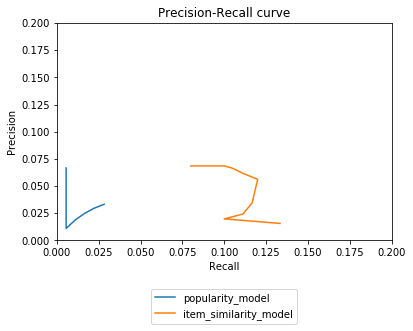

In [24]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")